In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from tqdm import tqdm

from pytorch_MNIST_ConvNet import MNIST_ConvNet

In [9]:
model = MNIST_ConvNet()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

C:\Users\solta\AppData\Local\Temp\ipykernel_22608\3776321210.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


MNIST_ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
# Convolutional layers
conv1_weights = model.conv1.weight.data
conv1_biases = model.conv1.bias.data
conv2_weights = model.conv2.weight.data
conv2_biases = model.conv2.bias.data

# Fully connected layers
fc1_weights = model.fc1.weight.data
fc1_biases = model.fc1.bias.data
fc2_weights = model.fc2.weight.data
fc2_biases = model.fc2.bias.data

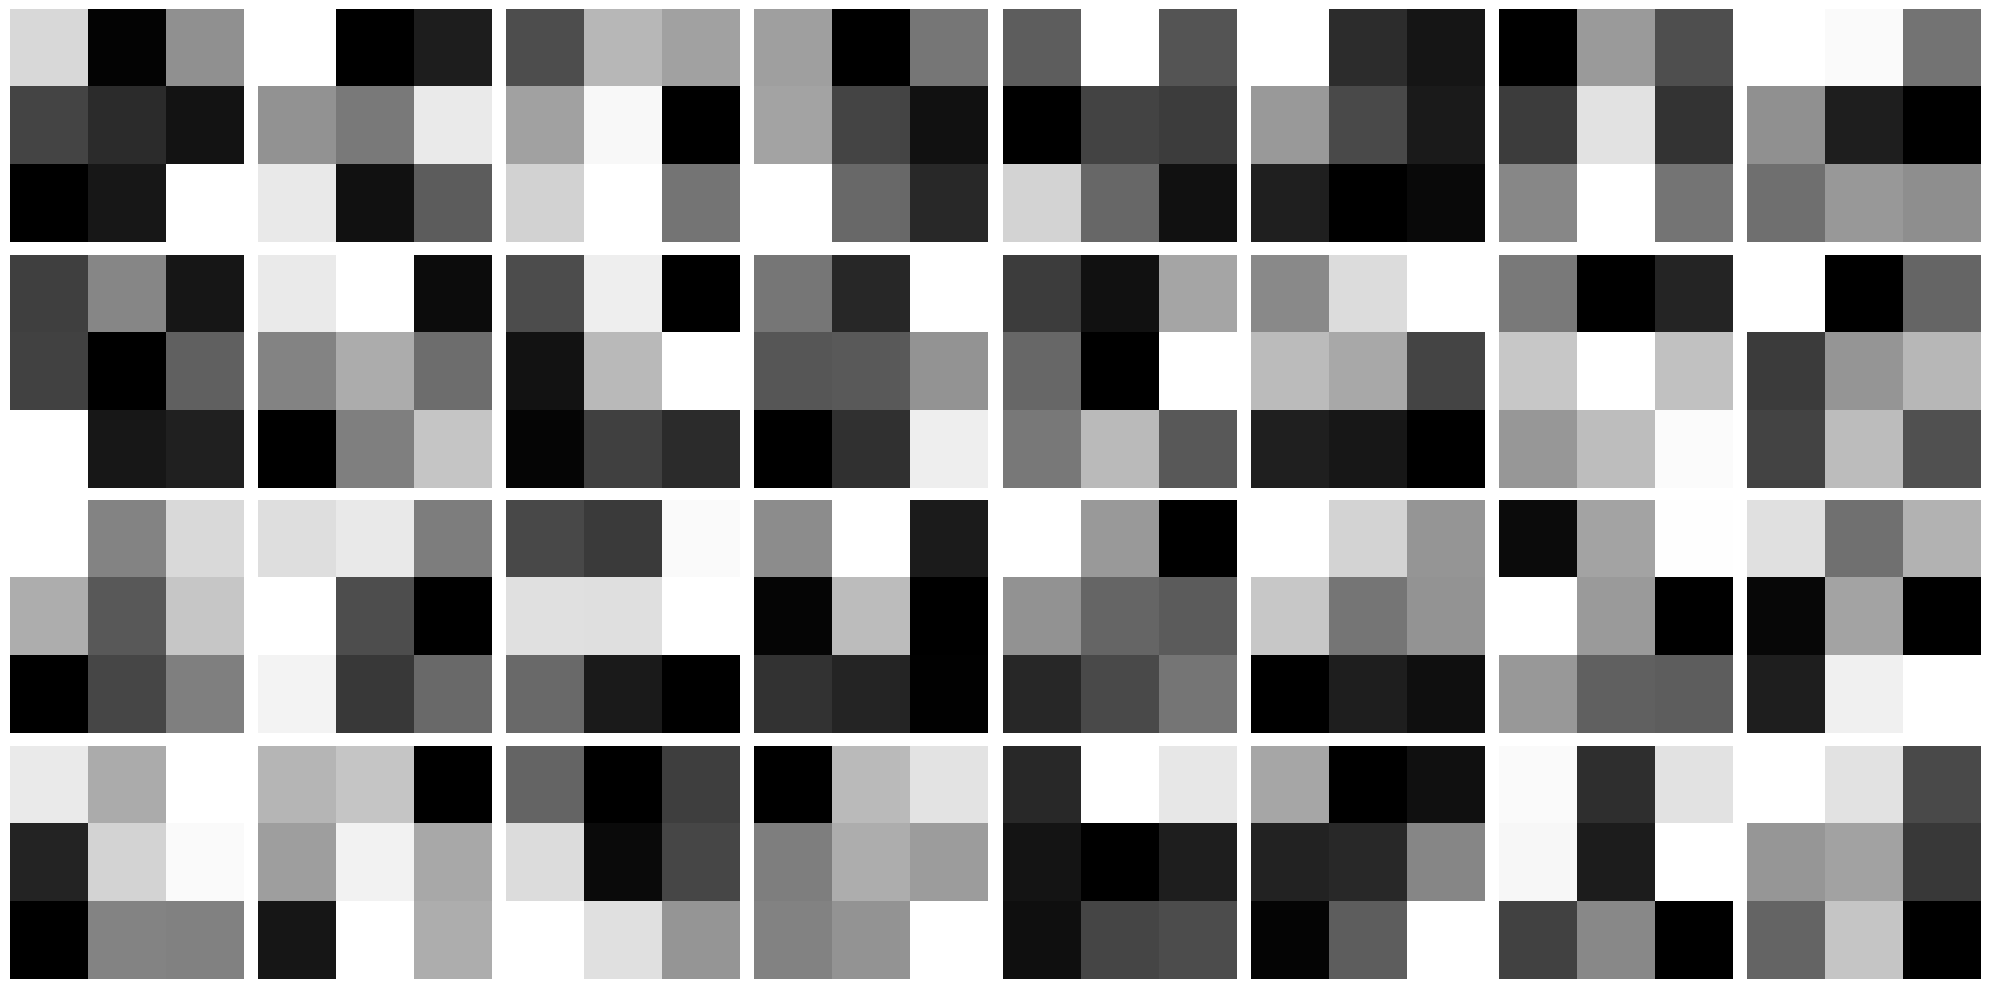

In [11]:
import matplotlib.pyplot as plt

def plot_filters(weights, num_filters=32):
    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(num_filters):
        ax = axs[i//8, i%8]
        ax.imshow(weights[i, 0].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_filters(conv1_weights)

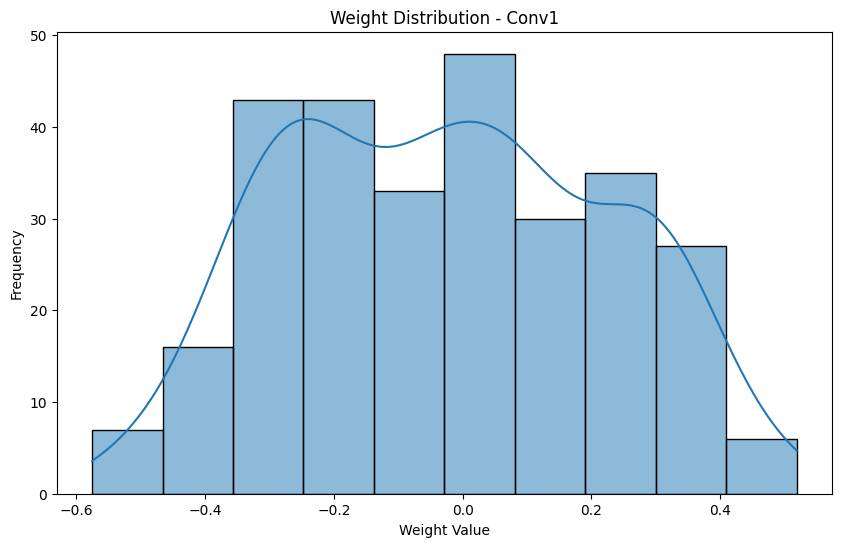

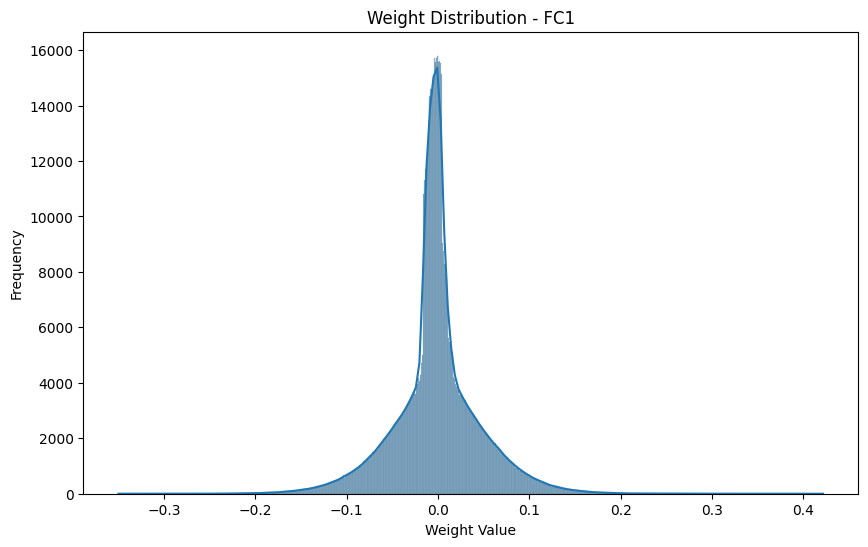

In [12]:
import seaborn as sns

def plot_weight_distribution(weights, layer_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(weights.cpu().numpy().flatten(), kde=True)
    plt.title(f'Weight Distribution - {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

plot_weight_distribution(conv1_weights, 'Conv1')
plot_weight_distribution(fc1_weights, 'FC1')

In [13]:
def top_connections(weights, top_n=10):
    flat_weights = weights.abs().flatten()
    top_values, top_indices = flat_weights.topk(top_n)
    return top_values, top_indices

top_values, top_indices = top_connections(fc2_weights)
print("Top 10 strongest connections in the output layer:")
for value, idx in zip(top_values, top_indices):
    print(f"Weight: {value.item():.4f}, Index: {idx.item()}")

Top 10 strongest connections in the output layer:
Weight: 0.2971, Index: 125
Weight: 0.2809, Index: 809
Weight: 0.2625, Index: 41
Weight: 0.2596, Index: 114
Weight: 0.2542, Index: 154
Weight: 0.2433, Index: 1196
Weight: 0.2388, Index: 104
Weight: 0.2343, Index: 566
Weight: 0.2339, Index: 568
Weight: 0.2315, Index: 754


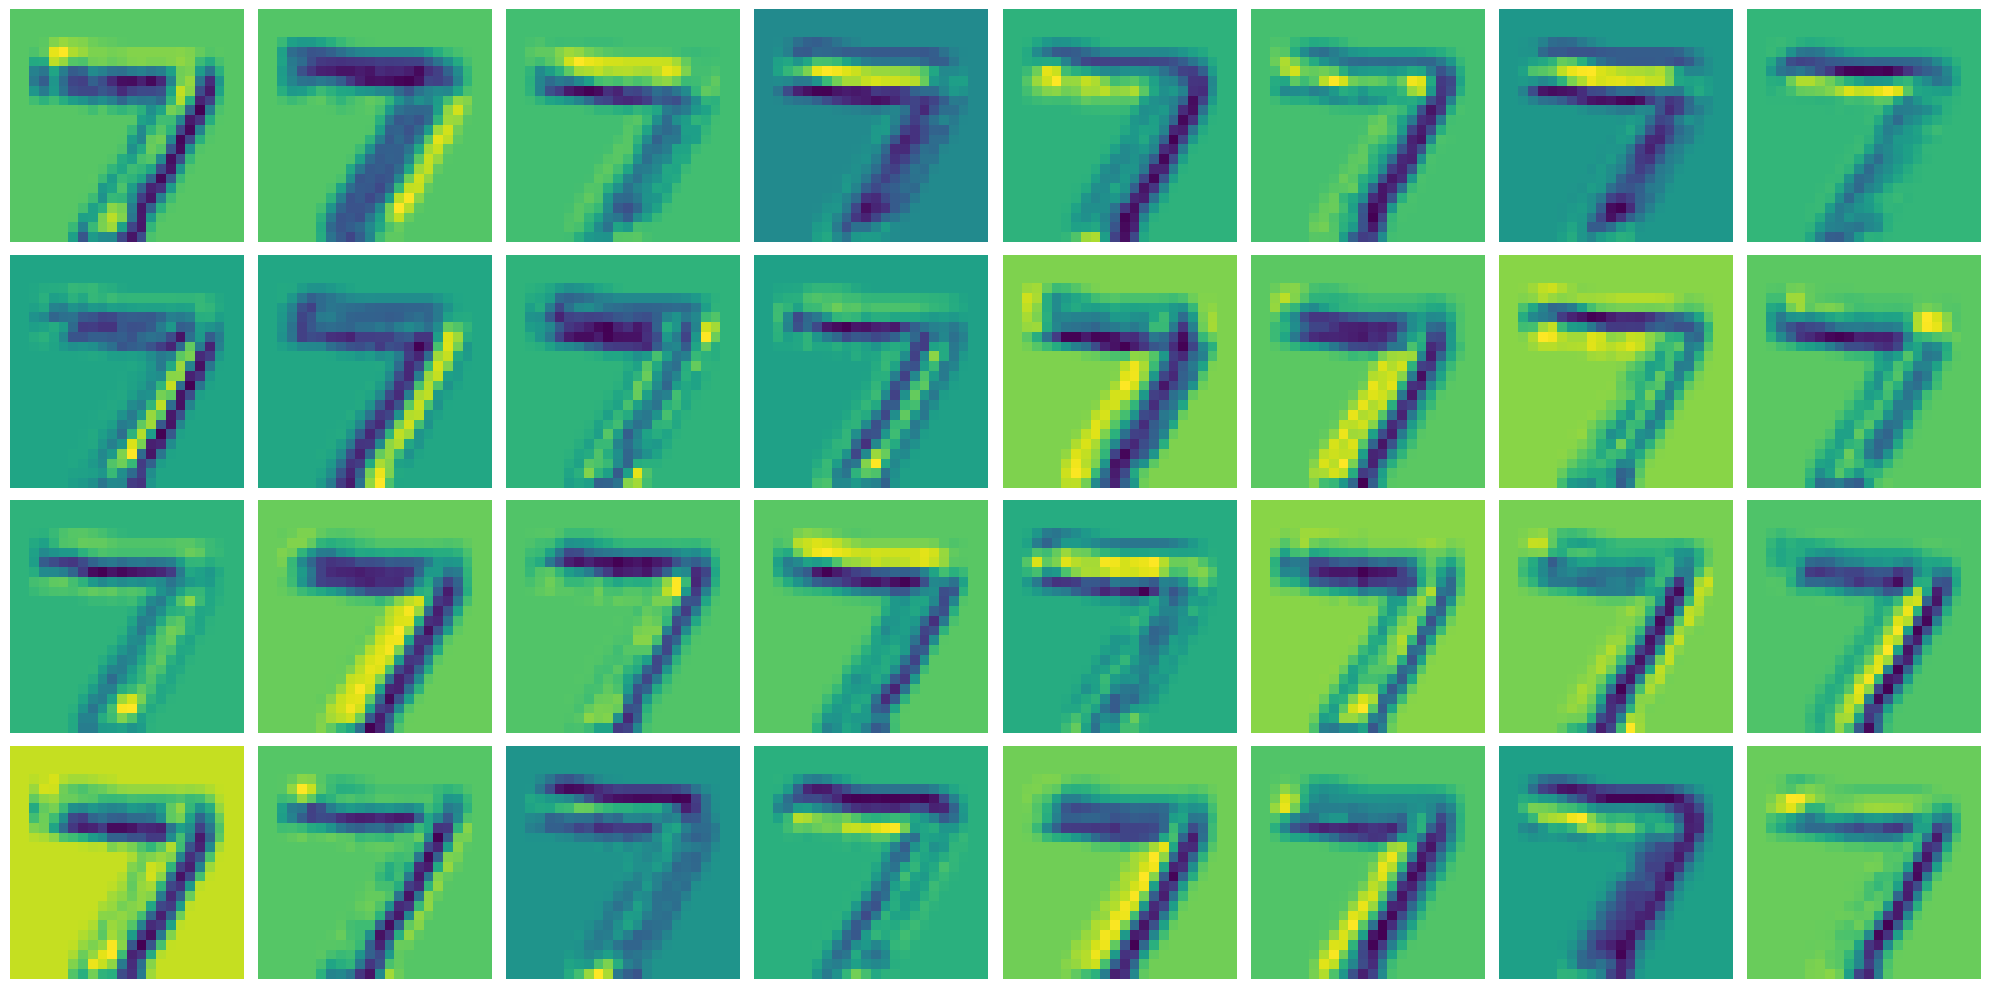

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

def visualize_layer_output(model, layer, input_image):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    layer.register_forward_hook(get_activation('conv'))
    model(input_image.unsqueeze(0))
    
    act = activation['conv'].squeeze().cpu()
    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(32):
        ax = axs[i//8, i%8]
        ax.imshow(act[i], cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming you have a sample input image
sample_image, _ = next(iter(test_loader))
visualize_layer_output(model, model.conv2, sample_image[0])